In [1]:
import inspect
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import pymc3 as pm
from pymc3 import sampling_jax

import theano.tensor as tt
import arviz as az

# %matplotlib

/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/pymc3/sampling_jax.py:24: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

frac_age  delta_nu_fit      nu_max  nu_0_1     nu_0_2     nu_0_3  \
0  0.000016     11.884045  150.680452     0.0  34.481794  49.329712   
1  0.000017     12.140476  154.893200     0.0  35.203007  50.376320   
2  0.000017     12.343045  158.238356     0.0  35.772049  51.202159   
3  0.000018     12.503403  160.898485     0.0  36.222266  51.855582   
4  0.000018     12.633487  163.061612     0.0  36.587368  52.385499   

      nu_0_4     nu_0_5     nu_0_6      nu_0_7  ...     nu_0_32     nu_0_33  \
0  63.195077  75.913367  87.630758   99.483102  ...  392.064627  403.710370   
1  64.548471  77.583389  89.569246  101.679667  ...  400.620086  412.538305   
2  65.616199  78.900744  91.100159  103.413323  ...  407.368711  419.505074   
3  66.460893  79.942765  92.312228  104.785371  ...  412.708426  425.019262   
4  67.145867  80.787635  93.295718  105.898357  ...  417.037759  429.491253   

      nu_0_34     nu_0_35     nu_0_36     nu_0_37     nu_0_38     nu_0_39  \
0  415.297909  426.924218  438.655667  450.550178  462.546781  474.658899   
1  424.386957  436.252351  448.212638  460.326691  472.558635  484.919720   
2  431.563921  443.619056  455.762984  468.048949  480.469626  493.018551   
3  437.245702  449.452226  461.742276  474.164224  486.734715  499.427290   
4  441.854064  454.184875  466.594022  479.127384  491.819429  504.626946   

      nu_0_40  surface_he4  
0  486.825847     0.239966  
1  497.325734     0.239967  
2  505.616340     0.239968  
3  512.179364     0.239969  
4  517.505773     0.239969  

[5 rows x 44 columns]

In [3]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
nu

array([1462.27571298, 1591.71073593, 1719.49277863, 1847.04715688,
       1975.37585221, 2103.70865688, 2230.4634227 , 2356.93239647,
       2483.78162935, 2611.8985408 , 2740.53392867, 2869.15043926,
       2997.963176  , 3126.77337843, 3256.15970241, 3385.89809743,
       3515.94349483, 3646.10714887, 3776.26474691, 3906.62692869])

In [6]:
# Scaling relation nu_max
numax = profile['nu_max']
print('numax ~', round(numax, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
dnu = profile['delta_nu_fit']
print('dnu ~', round(dnu, 2), 'muHz')

numax ~ 2853.19 muHz
dnu ~ 128.7 muHz


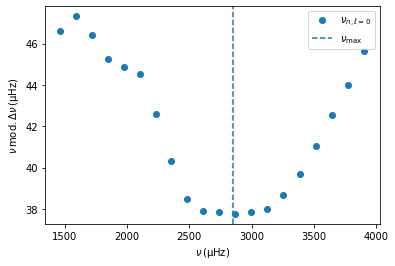

In [7]:
numod = nu % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [8]:
def asy_background(n, epsilon, alpha, delta_nu, nu_max):
    n_max = nu_max / delta_nu - epsilon
    return delta_nu * (n + epsilon + 0.5 * alpha * (n - n_max)**2)

def he_amplitude(nu, b0, b1, lib=tt):
    return b0 * nu * lib.exp(- b1 * nu**2)

def he_glitch(nu, b0, b1, tau_he, phi_he, lib=tt):
    return he_amplitude(nu, b0, b1, lib=lib) * lib.sin(4 * np.pi * tau_he * nu + phi_he)

In [9]:
1/numax

0.00035048457232552424

In [10]:
n = np.arange(10, 30)

epsilon = 1.3
alpha = 0.001
b0 = 10/numax
b1 = 2/numax**2
tau_he = 0.0006
phi_he = np.pi-0.01

delta_nu = dnu
nu_max = numax - 100

glitch = he_glitch(nu, b0, b1, tau_he, phi_he, lib=np)
asy = asy_background(n, epsilon, alpha, delta_nu, nu_max)
model = asy + glitch

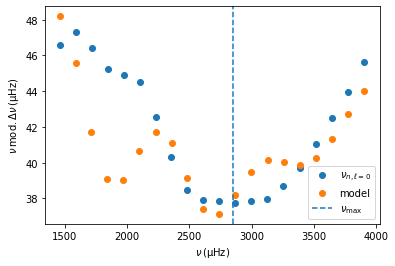

In [11]:
numod = nu % dnu
modelmod = model % dnu

fig, ax = plt.subplots()

ax.plot(nu, numod, 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, modelmod, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

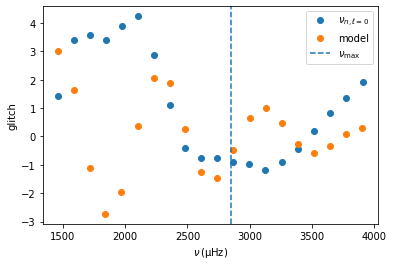

In [12]:
fig, ax = plt.subplots()

ax.plot(nu, nu - asy , 'o', label=r'$\nu_{n,\ell = 0}$')
ax.plot(model, glitch, 'o', label=r'model')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [13]:
with pm.Model() as model_asy:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', tt.log(0.001), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)

    nu_err = pm.HalfNormal('nu_err', 0.1)

    nu_model = pm.Deterministic('nu_model', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [14]:
from pymc3 import sampling_jax

In [15]:
with model_asy:
    trace_asy = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:12.858464
Transformation time =  0 days 00:00:01.151705


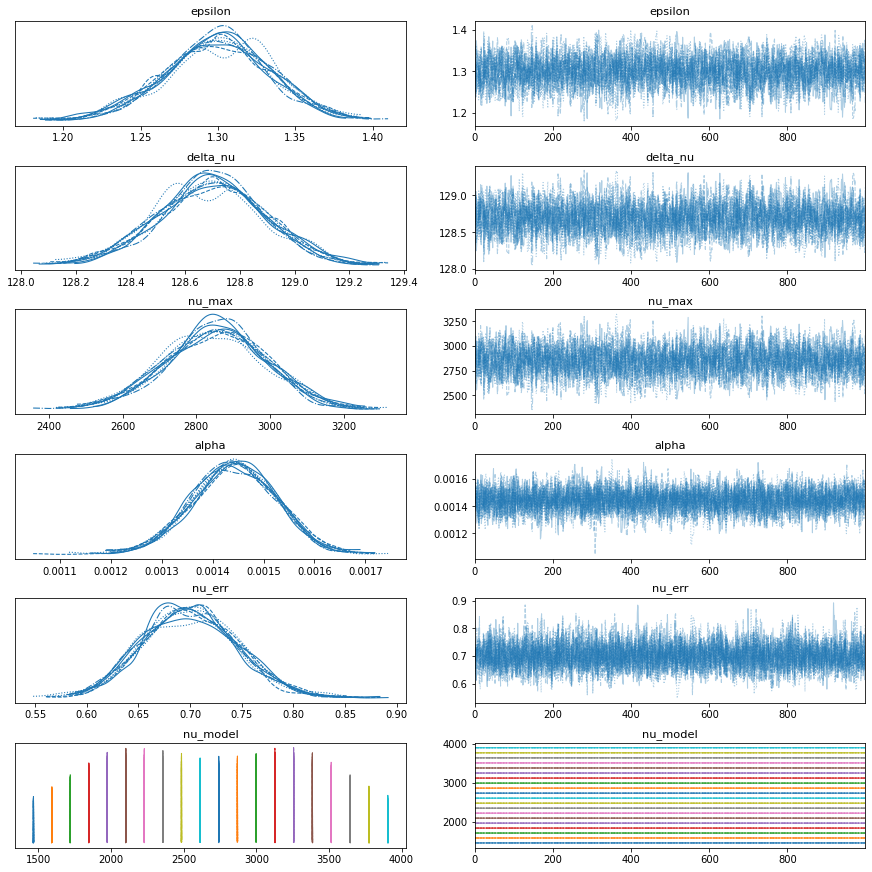

In [16]:
with model_asy:
    ax = az.plot_trace(trace_asy, compact=True)

In [17]:
with model_asy:
    df = az.summary(trace_asy)
df.head()

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
epsilon      1.300    0.034     1.232     1.362      0.001    0.000    2707.0   
delta_nu   128.695    0.199   128.321   129.070      0.004    0.003    2706.0   
nu_max    2853.089  136.573  2599.951  3112.821      2.603    1.845    2750.0   
alpha        0.001    0.000     0.001     0.002      0.000    0.000    4819.0   
nu_err       0.701    0.046     0.619     0.787      0.001    0.000    5236.0   

          ess_tail  r_hat  
epsilon     3639.0    1.0  
delta_nu    3675.0    1.0  
nu_max      3900.0    1.0  
alpha       4256.0    1.0  
nu_err      5072.0    1.0

In [27]:
nu_model = trace_asy.posterior['nu_model'].values

In [28]:
nu_model = nu_model.reshape(
        (nu_model.shape[0]*nu_model.shape[1],
         nu_model.shape[2])
    )
nu_model.shape

(10000, 20)

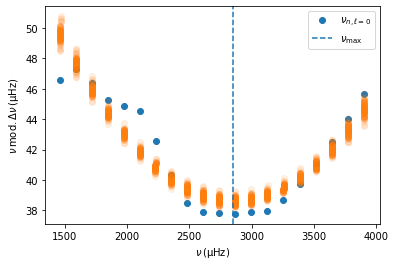

In [36]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_model[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [97]:
with pm.Model() as model_glitch:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2)
    alpha = pm.Lognormal('alpha', tt.log(1e-3), 1.0)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0)
    nu_max = pm.Normal('nu_max', numax, numax*0.05)
    
    b0 = pm.Lognormal('b0', tt.log(1/numax), 1.0)
    b1 = pm.Lognormal('b1', tt.log(1/numax**2), 1.0)
    tau = pm.Lognormal('tau', tt.log(0.001), 0.5)
    phi = pm.VonMises('phi', 0.0, 1.0)

    nu_err = pm.HalfNormal('nu_err', 0.1)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(n, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nu)

In [98]:
with model_glitch:
    trace_glitch = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:19.930629
Transformation time =  0 days 00:00:33.668693


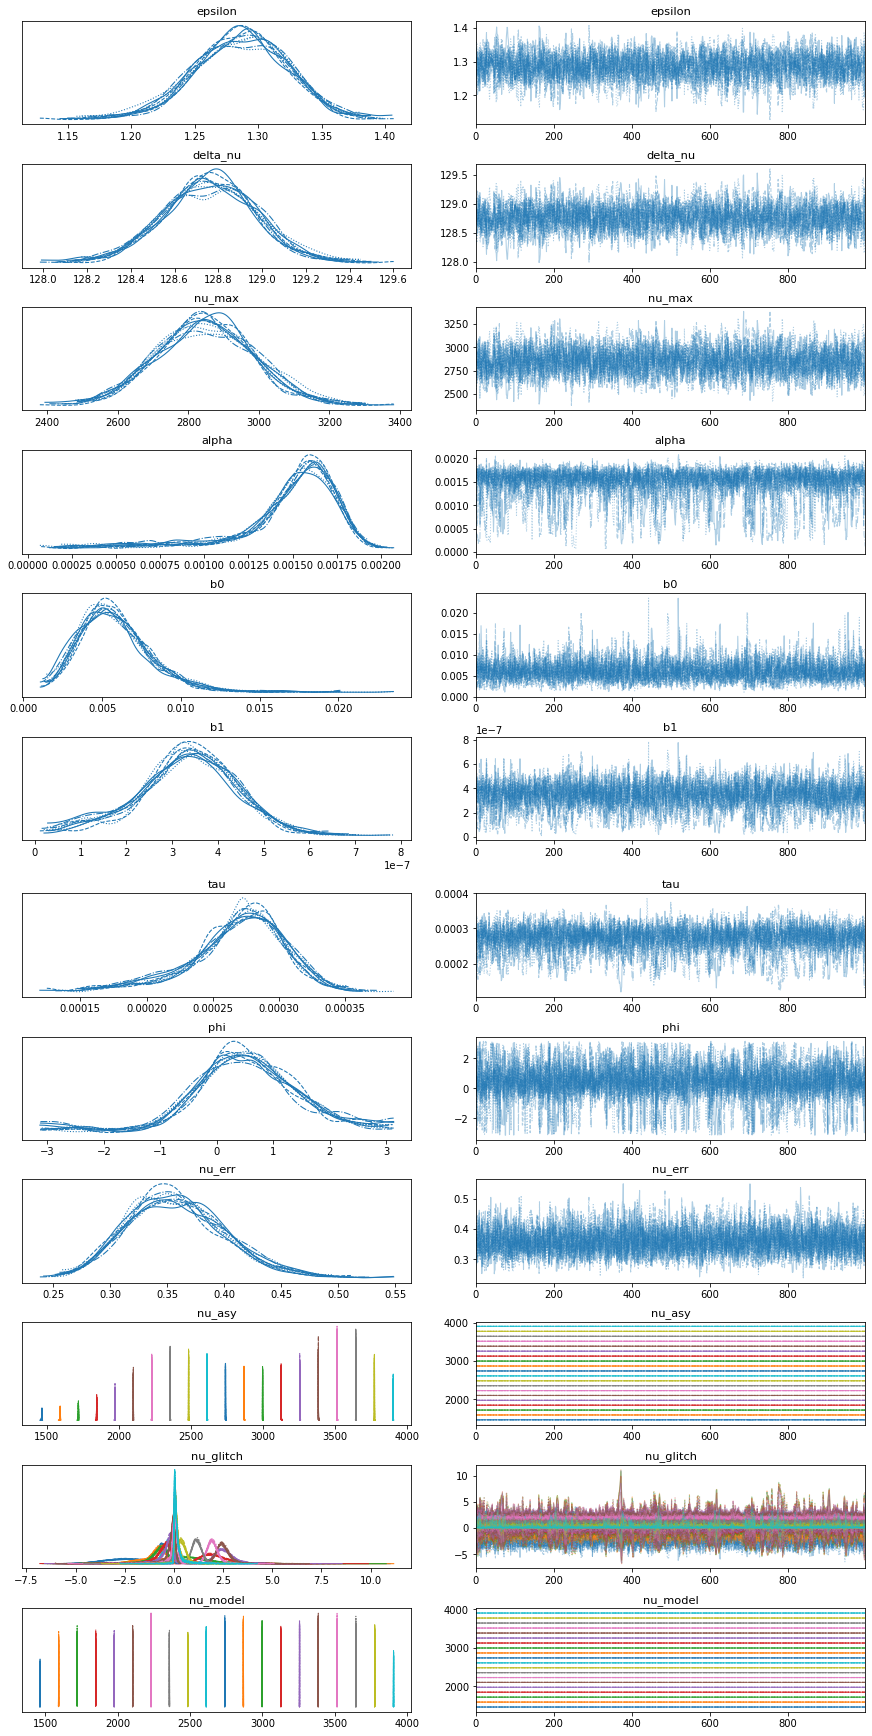

In [99]:
with model_glitch:
    ax = az.plot_trace(trace_glitch, compact=True)

In [40]:
nu_glitch = trace_glitch.posterior['nu_glitch'].values

In [41]:
nu_glitch = nu_glitch.reshape(
        (nu_glitch.shape[0]*nu_glitch.shape[1],
         nu_glitch.shape[2])
    )
nu_glitch.shape

(10000, 20)

In [42]:
nu_model = trace_glitch.posterior['nu_model'].values

In [43]:
nu_model = nu_model.reshape(
        (nu_model.shape[0]*nu_model.shape[1],
         nu_model.shape[2])
    )
nu_model.shape

(10000, 20)

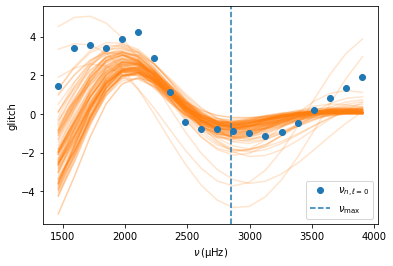

In [50]:
n_samples = 100
samples = np.random.choice(np.arange(nu_model.shape[0]), size=n_samples)

fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_glitch[samples].T, '-', color='C1', alpha=0.2)
ax.plot(nu, nu - asy , 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'glitch')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

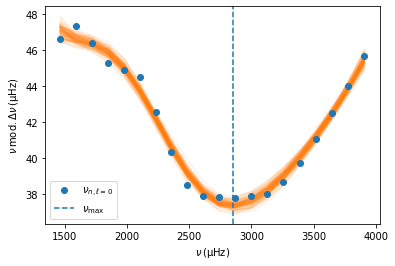

In [54]:
fig, ax = plt.subplots()

ax.plot(nu_model[samples].T, nu_model[samples].T % dnu, '-', color='C1', alpha=0.1)
ax.plot(nu, nu % dnu, 'o', label=r'$\nu_{n,\ell = 0}$')

ax.axvline(numax, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

## Model many

In [84]:
# profile = track.loc[track['frac_age'] < 0.5].iloc[-1]
n_stars = 10
profiles = track.loc[(track['frac_age'] > 0.01) & (track['frac_age'] < 0.8)].sample(n_stars)
profiles

frac_age  delta_nu_fit       nu_max  nu_0_1  nu_0_2      nu_0_3  \
688  0.731421    114.800787  2442.267004     0.0     0.0  466.712108   
476  0.163671    148.236820  3468.040335     0.0     0.0  577.231544   
655  0.653104    119.956589  2592.126669     0.0     0.0  484.411934   
616  0.555045    126.149028  2776.266101     0.0     0.0  505.163712   
644  0.625962    121.701480  2643.591563     0.0     0.0  490.309304   
596  0.502810    129.336544  2872.538278     0.0     0.0  515.664058   
537  0.341103    138.706736  3162.754915     0.0     0.0  546.213588   
441  0.057832    153.800900  3650.054326     0.0     0.0  595.518690   
640  0.615989    122.336097  2662.402974     0.0     0.0  492.444479   
687  0.729137    114.953170  2446.651474     0.0     0.0  467.242421   

         nu_0_4      nu_0_5       nu_0_6       nu_0_7  ...      nu_0_32  \
688  582.724325  702.073272   823.320248   944.252923  ...  3825.260287   
476  734.537618  895.750771  1056.221476  1215.397773  ...  4957.332034   
655  605.910796  731.574612   858.723317   985.564671  ...  3998.640552   
616  633.774352  767.180491   901.503874  1035.479629  ...  4210.212939   
644  613.756235  741.591662   870.751687   999.601589  ...  4059.353089   
596  648.130719  785.536115   923.589456  1061.223809  ...  4317.815105   
537  690.685640  839.922079   989.035094  1137.401396  ...  4634.498808   
441  760.382582  928.518872  1095.609191  1261.044319  ...  5145.664991   
640  616.611525  745.240196   875.133918  1004.714977  ...  4080.988805   
687  583.411135  702.944520   824.365082   945.471627  ...  3830.386543   

         nu_0_33      nu_0_34      nu_0_35      nu_0_36      nu_0_37  \
688  3938.456141  4049.844618  4158.461221  4264.047554  4368.268492   
476  5107.233189  5256.497811  5404.530343  5548.715771  5694.831966   
655  4117.777670  4235.503047  4350.857253  4463.223485  4572.964680   
616  4333.334259  4458.284070  4581.466182  4702.183923  4819.662468   
644  4178.508913  4298.303204  4415.901595  4530.626634  4642.454212   
596  4445.933361  4572.714006  4699.743667  4824.652414  4946.411609   
537  4774.178915  4912.271567  5047.515870  5184.086729  5318.354630   
441  5301.280787  5456.499637  5611.107472  5763.426331  5913.395089   
640  4200.610027  4321.151176  4439.560687  4555.146067  4667.753028   
687  3943.759816  4055.340066  4164.160085  4269.937992  4374.305734   

         nu_0_38      nu_0_39      nu_0_40  surface_he4  
688  4473.841346  4582.570364  4693.951714     0.202205  
476  5838.929910  5979.868588  6117.760621     0.231152  
655  4682.090549  4793.690017  4908.221793     0.206202  
616  4934.878464  5050.273967  5168.304273     0.211174  
644  4753.069843  4865.679979  4981.206492     0.207576  
596  5065.424412  5183.268845  5303.115270     0.213840  
537  5449.665616  5577.970435  5704.665801     0.222096  
441  6064.358418  6212.795375  6358.181712     0.236587  
640  4778.954245  4891.944039  5007.823764     0.208083  
687  4479.969784  4588.785435  4700.264335     0.202326  

[10 rows x 44 columns]

In [85]:
nus = profiles[nu_index].to_numpy().astype(float).T

In [86]:
nus.shape

(20, 10)

In [87]:
ns = n[:, np.newaxis]
ns.shape

(20, 1)

In [88]:
with pm.Model() as model_asy_many:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', tt.log(0.001), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numax, numax*0.05, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)

    nu_model = pm.Deterministic('nu_model', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    
    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [89]:
with model_asy_many:
    trace_asy_many = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:11.801818
Transformation time =  0 days 00:00:00.078622


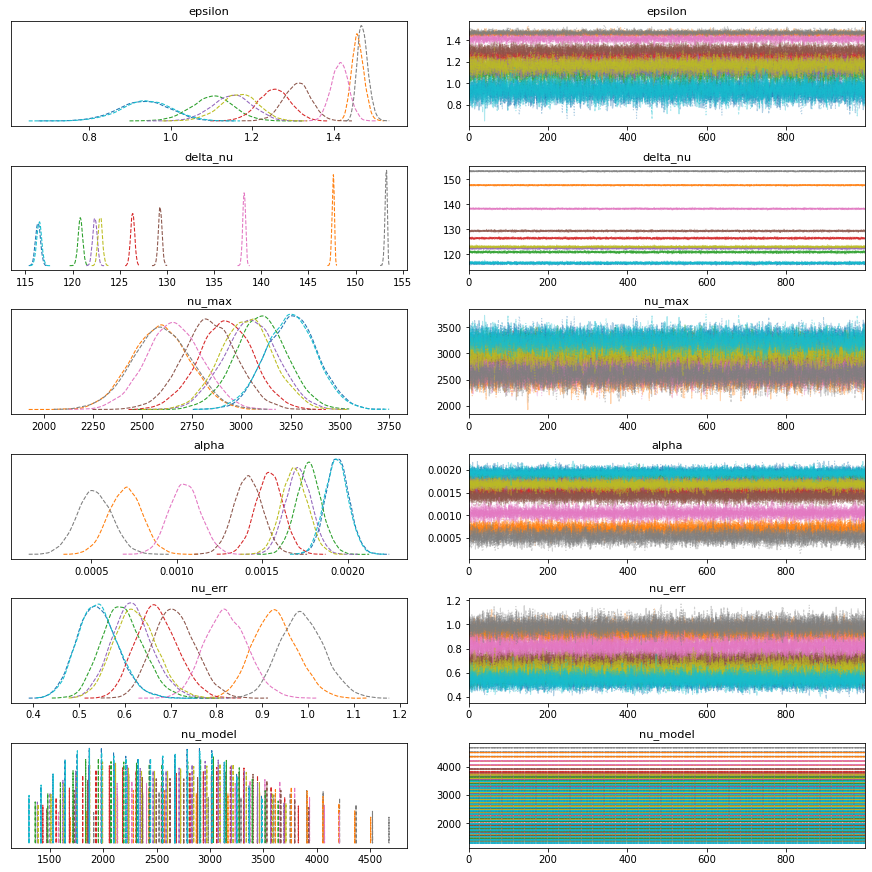

In [90]:
with model_asy_many:
    ax = az.plot_trace(trace_asy_many, compact=True, combined=True)

In [91]:
with pm.Model() as model_glitch_many:
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', tt.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numax, numax*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', tt.log(1/numax), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', tt.log(1/numax**2), 1.0, shape=n_stars)
    tau = pm.Lognormal('tau', tt.log(0.001), 0.5, shape=n_stars)
    phi = pm.VonMises('phi', 0.0, 1.0, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [92]:
with model_glitch_many:
    trace_glitch_many = sampling_jax.sample_numpyro_nuts(tune=2000, chains=10, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:25.332101
Transformation time =  0 days 00:12:10.556599


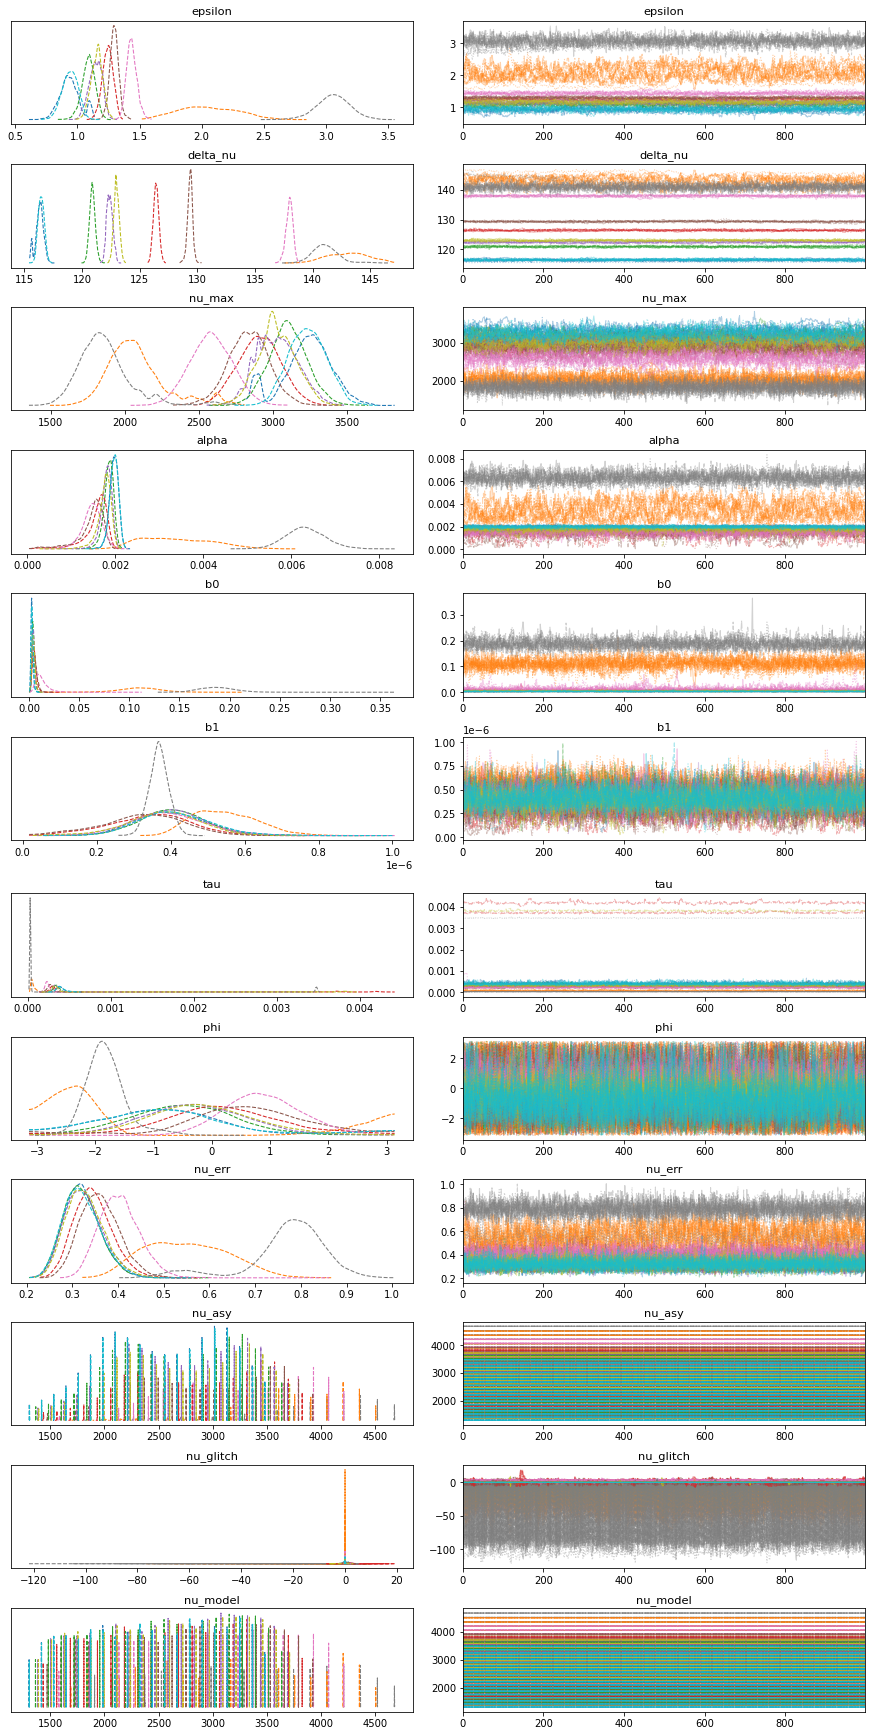

In [93]:
with model_glitch_many:
    ax = az.plot_trace(trace_glitch_many, compact=True, combined=True)

In [122]:
with pm.Model() as model_glitch_pooled:
    
    d = pm.Lognormal('d', 0.0, 0.5)
    m = pm.Lognormal('m', 0.0, 0.5)
    
    epsilon = pm.Normal('epsilon', 1.3, 0.2, shape=n_stars)
    alpha = pm.Lognormal('alpha', np.log(1e-3), 1.0, shape=n_stars)
    delta_nu = pm.Normal('delta_nu', dnu, 1.0, shape=n_stars)
    nu_max = pm.Normal('nu_max', numax, numax*0.05, shape=n_stars)
    
    b0 = pm.Lognormal('b0', np.log(1/numax), 1.0, shape=n_stars)
    b1 = pm.Lognormal('b1', np.log(1/numax**2), 1.0, shape=n_stars)
    tau = pm.Deterministic('tau', d * nu_max**(-m))
    phi = pm.VonMises('phi', 0.0, 3.0, shape=n_stars)

    nu_err = pm.HalfNormal('nu_err', 0.1, shape=n_stars)
    
    nu_asy = pm.Deterministic('nu_asy', asy_background(ns, epsilon, alpha, delta_nu, nu_max))
    nu_glitch = pm.Deterministic('nu_glitch', he_glitch(nu_asy, b0, b1, tau, phi))
    
    nu_model = pm.Deterministic('nu_model', nu_asy + nu_glitch)

    nu_obs = pm.Normal('nu_obs', nu_model, nu_err, observed=nus)

In [123]:
with model_glitch_pooled:
    trace_glitch_pooled = sampling_jax.sample_numpyro_nuts(tune=2000, chains=4, target_accept=0.95)

Compiling...


/Users/ajl573/.virtualenvs/base/lib/python3.8/site-packages/jax/interpreters/xla.py:682: UserWarning: The jitted function _sample includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warn(f"The jitted function {fun.__name__} includes a pmap. Using "


Compilation + sampling time =  0 days 00:00:18.571422
Transformation time =  0 days 00:03:39.215947


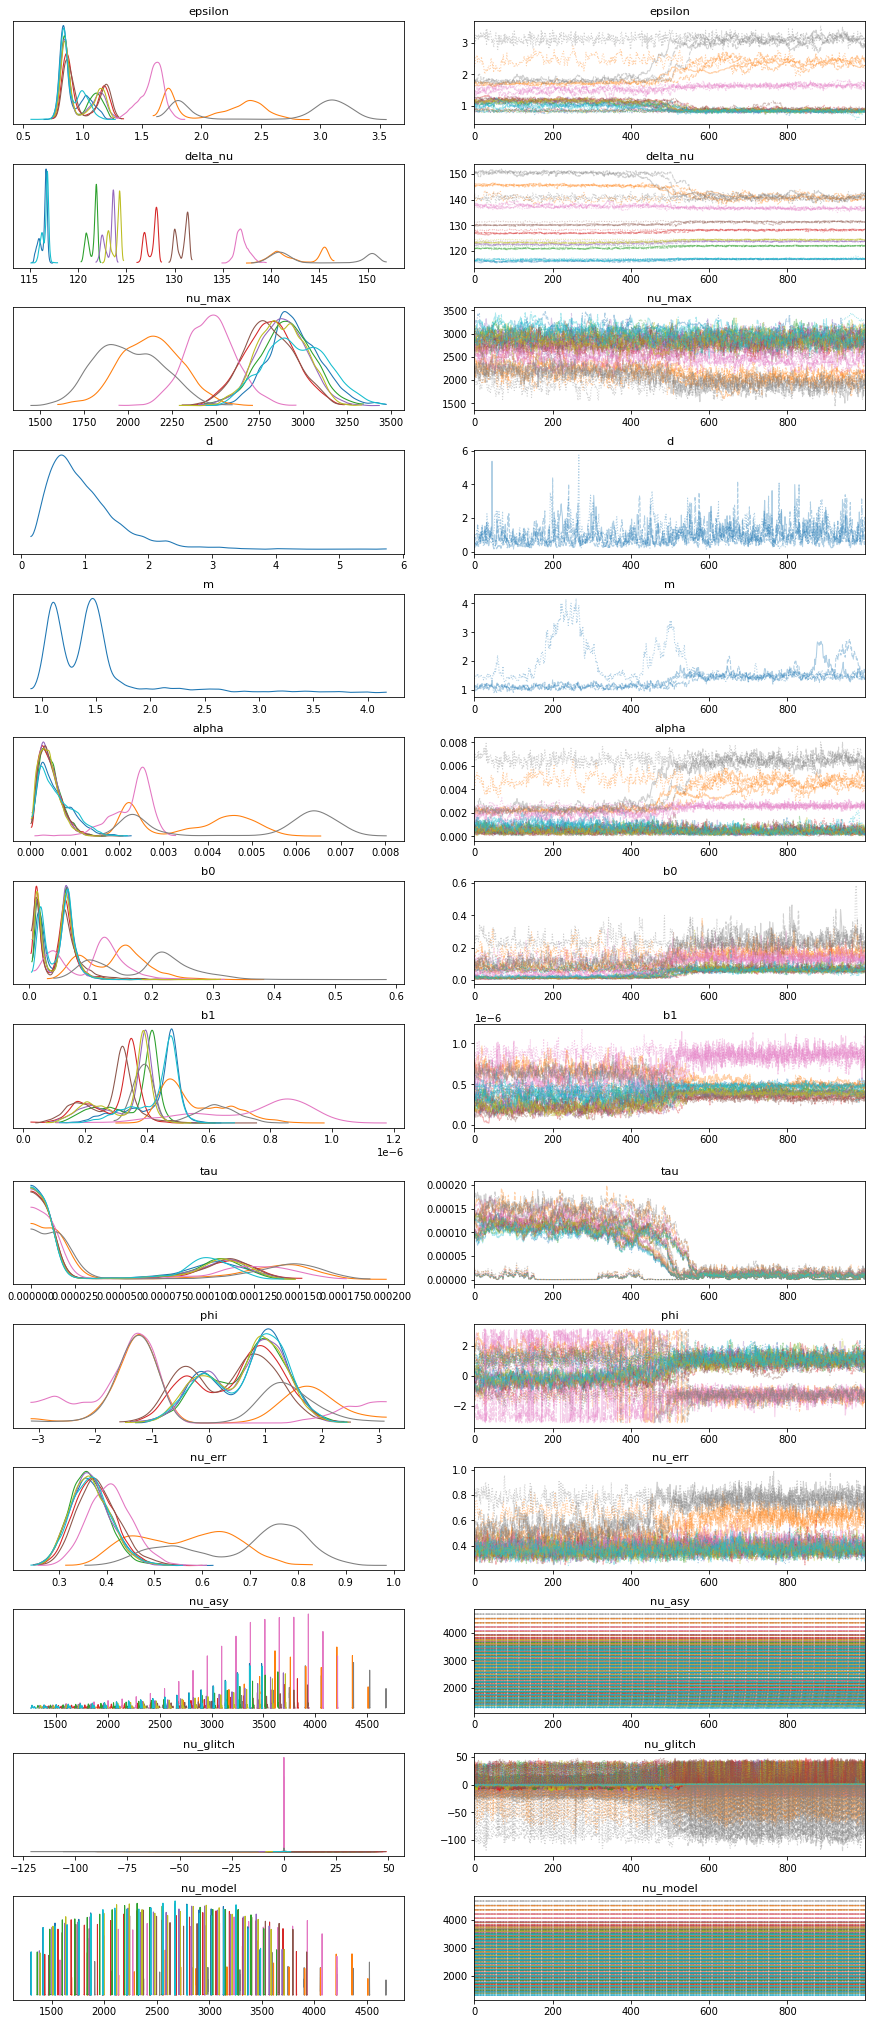

In [124]:
with model_glitch_pooled:
    ax = az.plot_trace(trace_glitch_pooled, compact=True, combined=True)